In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score
import seaborn as sns
from collections import Counter
import re

pd.set_option('display.max_colwidth', None)

In [63]:
df = pd.read_excel(r"C:\Users\Dnin\Desktop\bidnet_dataset.xlsx")
df.head()

,Title,Description,Tags,Relevant?
0,"E-Rate Cat. 2 - Wireless Network, UPS units, Data Cabling, Hardware Maintenance","The Denver Public Library (DPL) is seeking proposals for E-rate Category Two Equipment and Services - Basic Maintenance of Internal Connections, WiFi system refresh, Ad Hoc Data Cabling installation as needed, and/or UPS Units for Data Closets from vendors that have proven capable of provinding these goods and services comparable in size and scope to DPL’s. DPL is an independent agency of the City and County of Denver.",None,No
1,009-24 RFP Interpretation and Translation Services,"DCSD is requesting proposals from qualified firms or individuals for foreign and sign language interpretation and translation services needed to assist English-only speaking employees with stakeholder(s) who are hearing impaired or speak a foreign language.\nSUBMIT TO:\nDouglas County School District RE-1 (“DCSD”)\nvia:\nDCSD’s Workday Strategic Sourcing portal, which can be accessed via the link below.\nSuppliers must submit their bids within this portal.\nhttps://us.workdayspend.com/rfps/public/586486",None,No
2,Survive and Thrive: Application and Payment Provider,Boulder County Department of Housing and Human Services is seeking to contract with a business support entity for our Survive and Thrive Program.,None,No
3,Parking Garage & Parking Lot Security Services,The City of Colorado Springs Parking System Enterprise is seeking proposals to provide unarmed security services to 3 of our garages in Downtown Colorado Springs and a bicycle patrol for four of our parking lots in Old Colorado City.,None,No
4,Eaton UPS Replacements FY24,The University of Northern Colorado (“University” or “UNC”) seeks pricing for replacement Eaton UPS equipment. All equipment must be NEW. No substitutions will be considered,None,No


In [64]:
#model = SentenceTransformer('all-mpnet-base-v2')
# model = SentenceTransformer('multi-qa-mpnet-base-dot-v1')
model = SentenceTransformer('multi-qa-distilbert-cos-v1')

In [65]:
# keywords = ["digital transformation", "artificial intelligence", "machine learning", "analytics", "data engineering",\
#             "salesforce", "grants", "licensing and permits", "lightning experience, lightning migration",\
#             "case management", "data warehouse", "automation", "rpa ; robotic process automation" , "consultancy", "advisory",\
#            "application development and maintenance"]

keywords = ["digital transformation", "artificial intelligence", "machine learning", "analytics", "data engineering",\
            "salesforce", "grants", "licensing", "permits", "lightning experience", "lightning migration",\
            "case management", "data warehouse", "automation", "rpa", "robotic process automation" , "consultancy", "advisory",\
           "application development"]

keyword_embeddings = np.array([model.encode(keyword) for keyword in keywords])

In [66]:
keyword_embeddings.shape

(19, 768)

In [67]:
def calculate_cosine_similarity(description_embedding):
#     scores= {}
#     for keyword, keyword_embedding in zip(keywords, keyword_embeddings):
#         # Calculate dot product score directly without normalization
#         score = np.dot(keyword_embedding, description_embedding)
#         scores[keyword] = score
        
#     return scores
    similarities= {}
    for keyword, keyword_embedding in zip(keywords, keyword_embeddings):
        similarity = cosine_similarity([keyword_embedding], [description_embedding])[0][0]
        similarities[keyword] = similarity
        #print(f"Similarity with '{keyword}':", similarities[keyword])
        
    return similarities

def predict_tags(row, model, keywords, keyword_embeddings, threshold):
    description = row['Description']
    print(row['Title'])
    words = re.findall(r'\b\w+\b', description)
    number_of_words = len(words)
    actual_tags = "No Tags" if row['Tags'] == "None" else row['Tags']
    description_embedding = model.encode(description)
    
    similarities_tags = calculate_cosine_similarity(description_embedding)

#     threshold = 18
#     predicted_tags = [keyword for keyword, score in similarities_tags.items() if score > threshold]
    
    print("Scores : ",similarities_tags)
    filtered_sorted_tags = sorted([(keyword, score) for keyword, score in similarities_tags.items() if score > threshold], key=lambda x: x[1], reverse=True)
    top_3_tags = [tag for tag, _ in filtered_sorted_tags[:3]]
#     print("Description:", description)
    print("Actual Tags: ", actual_tags)
    print("Predicted Tags: ", top_3_tags)
    
    return top_3_tags, number_of_words

def check_relevance(row):
    relevance = "Yes" if len(row['Most Relevant Tags']) > 0 else "No"
    return relevance

In [68]:
# Assuming 'model', 'keywords', 'keyword_embeddings' are defined
df[['Most Relevant Tags','Word Count']] = df.apply(lambda row: predict_tags(row, model, keywords, keyword_embeddings, 0.3), axis=1, result_type='expand')

E-Rate Cat. 2 - Wireless Network, UPS units, Data Cabling, Hardware Maintenance
Scores :  {'digital transformation': 0.16542599, 'artificial intelligence': 0.052290365, 'machine learning': 0.1158356, 'analytics': 0.10905491, 'data engineering': 0.25609118, 'salesforce': 0.2022925, 'grants': 0.18906803, 'licensing': 0.19622055, 'permits': 0.11273212, 'lightning experience': 0.1614899, 'lightning migration': 0.09563753, 'case management': 0.14807819, 'data warehouse': 0.32068586, 'automation': 0.14913014, 'rpa': 0.3224712, 'robotic process automation': 0.11269009, 'consultancy': 0.17400193, 'advisory': 0.17064305, 'application development': 0.044714615}
Actual Tags:  No Tags
Predicted Tags:  ['rpa', 'data warehouse']
009-24 RFP Interpretation and Translation Services
Scores :  {'digital transformation': 0.15519094, 'artificial intelligence': -0.0107015455, 'machine learning': 0.06079098, 'analytics': -0.009172608, 'data engineering': 0.057273455, 'salesforce': 0.12132614, 'grants': 0.188

Scores :  {'digital transformation': 0.12819716, 'artificial intelligence': 0.04249878, 'machine learning': 0.113161124, 'analytics': 0.16702247, 'data engineering': 0.18843481, 'salesforce': 0.14913711, 'grants': 0.13713762, 'licensing': 0.13050574, 'permits': 0.11682995, 'lightning experience': 0.09350949, 'lightning migration': 0.021071712, 'case management': 0.37846714, 'data warehouse': 0.2952433, 'automation': 0.17781615, 'rpa': 0.21941653, 'robotic process automation': 0.18780494, 'consultancy': 0.1968393, 'advisory': 0.14290917, 'application development': 0.16321844}
Actual Tags:  case management
Predicted Tags:  ['case management']
Labor Market Data Tool
Scores :  {'digital transformation': 0.04843027, 'artificial intelligence': 0.05371441, 'machine learning': 0.08358412, 'analytics': 0.07682335, 'data engineering': 0.170196, 'salesforce': 0.1975221, 'grants': 0.15468392, 'licensing': 0.19432648, 'permits': 0.23551203, 'lightning experience': 0.087934114, 'lightning migration'

Scores :  {'digital transformation': 0.04596007, 'artificial intelligence': 0.0014511612, 'machine learning': -0.036002368, 'analytics': 0.058392495, 'data engineering': 0.087778255, 'salesforce': 0.16668017, 'grants': 0.1431115, 'licensing': 0.08770288, 'permits': 0.101085454, 'lightning experience': 0.06294404, 'lightning migration': -0.023593534, 'case management': 0.17319848, 'data warehouse': 0.12484032, 'automation': 0.004527271, 'rpa': 0.35069767, 'robotic process automation': 0.011545601, 'consultancy': 0.23466936, 'advisory': 0.20473927, 'application development': 0.06416981}
Actual Tags:  No Tags
Predicted Tags:  ['rpa']
Identity Management System (IDMS)
Scores :  {'digital transformation': 0.116038725, 'artificial intelligence': 0.1622191, 'machine learning': 0.22965592, 'analytics': 0.04079581, 'data engineering': 0.2362015, 'salesforce': 0.17345402, 'grants': 0.1768749, 'licensing': 0.15878007, 'permits': 0.1330154, 'lightning experience': 0.034717187, 'lightning migration

Scores :  {'digital transformation': 0.13409564, 'artificial intelligence': -0.040789146, 'machine learning': 0.047182187, 'analytics': 0.017838541, 'data engineering': 0.07221359, 'salesforce': 0.13786066, 'grants': 0.09294716, 'licensing': 0.16663548, 'permits': 0.04709711, 'lightning experience': 0.13015363, 'lightning migration': 0.09952955, 'case management': 0.06265679, 'data warehouse': 0.17868805, 'automation': -0.064651534, 'rpa': 0.2527061, 'robotic process automation': -0.014439231, 'consultancy': 0.152657, 'advisory': 0.14397171, 'application development': -0.0128881}
Actual Tags:  No Tags
Predicted Tags:  []
Category 2 Internal Network Connections
Scores :  {'digital transformation': 0.07950649, 'artificial intelligence': -0.00086509436, 'machine learning': -0.0047483193, 'analytics': -0.016309166, 'data engineering': 0.07147014, 'salesforce': 0.13321759, 'grants': 0.2068764, 'licensing': 0.27993858, 'permits': 0.2218158, 'lightning experience': 0.10336875, 'lightning migr

Scores :  {'digital transformation': 0.033203762, 'artificial intelligence': 0.20071855, 'machine learning': 0.1495208, 'analytics': 0.19497888, 'data engineering': 0.15375133, 'salesforce': 0.18076035, 'grants': 0.15191856, 'licensing': 0.095089436, 'permits': 0.15201733, 'lightning experience': -0.0528113, 'lightning migration': -0.036099594, 'case management': 0.19746259, 'data warehouse': 0.19616151, 'automation': 0.18313266, 'rpa': 0.2114663, 'robotic process automation': 0.17595483, 'consultancy': 0.122724116, 'advisory': 0.101183176, 'application development': 0.17507571}
Actual Tags:  data warehouse, application development, digital transformation
Predicted Tags:  []
Operator Certification Enhancements, Maintenance and Support
Scores :  {'digital transformation': 0.062248655, 'artificial intelligence': 0.13477966, 'machine learning': 0.09734534, 'analytics': 0.10000366, 'data engineering': 0.3160854, 'salesforce': 0.18233773, 'grants': 0.12090727, 'licensing': 0.19184786, 'perm

Scores :  {'digital transformation': 0.04414379, 'artificial intelligence': 0.14319333, 'machine learning': 0.1918362, 'analytics': 0.048255123, 'data engineering': 0.21813959, 'salesforce': 0.21593024, 'grants': 0.17575908, 'licensing': 0.17551191, 'permits': 0.10646847, 'lightning experience': 0.04964596, 'lightning migration': 0.062329974, 'case management': 0.24219595, 'data warehouse': 0.22538906, 'automation': 0.10188822, 'rpa': 0.4056053, 'robotic process automation': 0.17729801, 'consultancy': 0.24791321, 'advisory': 0.19547603, 'application development': 0.15226242}
Actual Tags:  application development
Predicted Tags:  ['rpa']
Cisco UCCX FLEX Licenses
Scores :  {'digital transformation': 0.12303491, 'artificial intelligence': 0.17657419, 'machine learning': 0.12594688, 'analytics': 0.060941286, 'data engineering': 0.23426837, 'salesforce': 0.28057963, 'grants': 0.15783525, 'licensing': 0.17993003, 'permits': 0.12675524, 'lightning experience': -0.017402582, 'lightning migrati

Scores :  {'digital transformation': 0.038324244, 'artificial intelligence': -0.004581169, 'machine learning': 0.019717755, 'analytics': -0.0076382626, 'data engineering': 0.054176804, 'salesforce': 0.09662475, 'grants': 0.006680114, 'licensing': 0.042038757, 'permits': 0.11595068, 'lightning experience': 0.054287616, 'lightning migration': 0.06845911, 'case management': 0.13626248, 'data warehouse': 0.050658002, 'automation': 0.034893814, 'rpa': 0.103959784, 'robotic process automation': 0.06990029, 'consultancy': 0.20430396, 'advisory': 0.21702507, 'application development': 0.030172704}
Actual Tags:  No Tags
Predicted Tags:  []
Concrete Improvements - Elizabeth Street Phase 2(Hwy 50 to 17th Street)
Scores :  {'digital transformation': -0.02016059, 'artificial intelligence': 0.0742797, 'machine learning': 0.06259308, 'analytics': -0.022625336, 'data engineering': 0.040919684, 'salesforce': 0.13510942, 'grants': 0.08765348, 'licensing': 0.09904617, 'permits': 0.21394424, 'lightning ex

Scores :  {'digital transformation': 0.026517812, 'artificial intelligence': 0.034436185, 'machine learning': 0.064928904, 'analytics': 0.1014777, 'data engineering': 0.002018923, 'salesforce': 0.15883476, 'grants': 0.07535316, 'licensing': 0.041533947, 'permits': 0.052474808, 'lightning experience': 0.004034534, 'lightning migration': -0.009862365, 'case management': 0.06638233, 'data warehouse': 0.078516856, 'automation': 0.054492887, 'rpa': 0.09556085, 'robotic process automation': 0.032036554, 'consultancy': -0.016142724, 'advisory': 0.027987782, 'application development': 0.14407223}
Actual Tags:  No Tags
Predicted Tags:  []
WELD COUNTY JAIL BOOKING RENOVATION
Scores :  {'digital transformation': -0.008909598, 'artificial intelligence': -0.043188646, 'machine learning': -0.095593184, 'analytics': -0.04682934, 'data engineering': -0.04764373, 'salesforce': 0.018608384, 'grants': 0.0881214, 'licensing': 0.071235426, 'permits': 0.14878266, 'lightning experience': 0.048144262, 'lightn

Scores :  {'digital transformation': 0.0075876703, 'artificial intelligence': 0.03913537, 'machine learning': 0.12100409, 'analytics': -0.043033376, 'data engineering': 0.049970526, 'salesforce': 0.1130822, 'grants': 0.18784204, 'licensing': 0.23844732, 'permits': 0.17580813, 'lightning experience': 0.157256, 'lightning migration': 0.1032819, 'case management': 0.15894718, 'data warehouse': 0.057161342, 'automation': 0.050864477, 'rpa': 0.15522301, 'robotic process automation': 0.0775191, 'consultancy': 0.29944915, 'advisory': 0.22759959, 'application development': 0.16401538}
Actual Tags:  No Tags
Predicted Tags:  []
76--COMMUNICATIONS - MEDIA, OUTLET AND CONTACT AND MEDIA MONITORING SUBSCRIPTION
Scores :  {'digital transformation': 0.1727257, 'artificial intelligence': 0.0018968042, 'machine learning': 0.059601672, 'analytics': 0.29890603, 'data engineering': 0.14623648, 'salesforce': 0.21686667, 'grants': -0.01636901, 'licensing': 0.14965495, 'permits': 0.049199127, 'lightning exper

Scores :  {'digital transformation': 0.039944038, 'artificial intelligence': -0.012141007, 'machine learning': 0.02470057, 'analytics': 0.018185424, 'data engineering': 0.045112986, 'salesforce': 0.08740048, 'grants': 0.0963513, 'licensing': 0.07648875, 'permits': 0.17253253, 'lightning experience': 0.034076463, 'lightning migration': 0.09227044, 'case management': 0.15384637, 'data warehouse': 0.21111827, 'automation': -0.042340282, 'rpa': 0.16939622, 'robotic process automation': 0.010374411, 'consultancy': 0.09207028, 'advisory': 0.12421064, 'application development': -0.016625224}
Actual Tags:  No Tags
Predicted Tags:  []
Portable Planetarium
Scores :  {'digital transformation': -0.06599502, 'artificial intelligence': 0.04125309, 'machine learning': -0.031398203, 'analytics': 0.12075406, 'data engineering': -0.0450479, 'salesforce': -0.01576922, 'grants': 0.14488, 'licensing': 0.11734043, 'permits': 0.088019684, 'lightning experience': -0.075996116, 'lightning migration': -0.022683

In [69]:
df['Predicted Relevance'] = df.apply(check_relevance, axis=1)
df

,Title,Description,Tags,Relevant?,Most Relevant Tags,Word Count,Predicted Relevance
0,"E-Rate Cat. 2 - Wireless Network, UPS units, Data Cabling, Hardware Maintenance","The Denver Public Library (DPL) is seeking proposals for E-rate Category Two Equipment and Services - Basic Maintenance of Internal Connections, WiFi system refresh, Ad Hoc Data Cabling installation as needed, and/or UPS Units for Data Closets from vendors that have proven capable of provinding these goods and services comparable in size and scope to DPL’s. DPL is an independent agency of the City and County of Denver.",None,No,"[rpa, data warehouse]",70,Yes
1,009-24 RFP Interpretation and Translation Services,"DCSD is requesting proposals from qualified firms or individuals for foreign and sign language interpretation and translation services needed to assist English-only speaking employees with stakeholder(s) who are hearing impaired or speak a foreign language.\nSUBMIT TO:\nDouglas County School District RE-1 (“DCSD”)\nvia:\nDCSD’s Workday Strategic Sourcing portal, which can be accessed via the link below.\nSuppliers must submit their bids within this portal.\nhttps://us.workdayspend.com/rfps/public/586486",None,No,[],76,No
2,Survive and Thrive: Application and Payment Provider,Boulder County Department of Housing and Human Services is seeking to contract with a business support entity for our Survive and Thrive Program.,None,No,[],23,No
3,Parking Garage & Parking Lot Security Services,The City of Colorado Springs Parking System Enterprise is seeking proposals to provide unarmed security services to 3 of our garages in Downtown Colorado Springs and a bicycle patrol for four of our parking lots in Old Colorado City.,None,No,[],39,No
4,Eaton UPS Replacements FY24,The University of Northern Colorado (“University” or “UNC”) seeks pricing for replacement Eaton UPS equipment. All equipment must be NEW. No substitutions will be considered,None,No,[],25,No
...,...,...,...,...,...,...,...
120,Modified - Financial Mmgt Service Provider - Housing & Urban Development Housing,"The purpose of this DQ is to obtain competitive quotations from qualified third party accounting firms with voucher program expertise that could assist the Division in understanding and reconciling the accounting associated with the DOH Housing Choice Voucher (HCV) program - including the 5-Year Mainstream Voucher and Emergency Housing Voucher components. A qualified Service Provider will be able to provide the deliverables list in Section VIII, for members of the DOLA HCV program and financial teams.\nAt the conclusion of this contract, it is expected that DOLA staff will have the knowledge and tools to carry forward with on-going financial management and reporting capability for the HCV program, supported by permanent financial and programmatic data structures that deliver repeatable and effective processes, data reliability, straight-forward data interpretation and efficient reporting.",data engineering,Yes,[],132,No
121,2024 Construction Manager as General Contractor Services High Note Regional Park,"The City of Lone Tree and its partner, South Suburban, (collectively “the Owner Team”) have hired The Architerra Group, a landscape architecture firm to lead the preliminary design for High Note Regional Park, a new regional park to be located near I-25 and Ridgegate Parkway. The Owner Team have identified financing to begin the first phase of an 80-acre regional park. It is anticipated that Phase 1 will have a hard cost budget between $12-19 million. The Owner Team is committed to realizing the full construction of High Note Regional Park as funding becomes available over the next few years. Now, the Owner Team seeks a collaborative CM/GC partner to join the Project Team.",None,No,[],118,No
122,Ridge View Residential Community Project Management,"Under legislation, SB22-211, The Department of Local Affairs (DOLA) is tasked with the redevelopment of the Ridge View Campus formally the Ridge View Yo

In [72]:
df['Tags'] = df['Tags'].apply(lambda x:[tag.strip() for tag in x.split(',')] if x != "None" else [])
df

,Title,Description,Tags,Relevant?,Most Relevant Tags,Word Count,Predicted Relevance
0,"E-Rate Cat. 2 - Wireless Network, UPS units, Data Cabling, Hardware Maintenance","The Denver Public Library (DPL) is seeking proposals for E-rate Category Two Equipment and Services - Basic Maintenance of Internal Connections, WiFi system refresh, Ad Hoc Data Cabling installation as needed, and/or UPS Units for Data Closets from vendors that have proven capable of provinding these goods and services comparable in size and scope to DPL’s. DPL is an independent agency of the City and County of Denver.",[],No,"[rpa, data warehouse]",70,Yes
1,009-24 RFP Interpretation and Translation Services,"DCSD is requesting proposals from qualified firms or individuals for foreign and sign language interpretation and translation services needed to assist English-only speaking employees with stakeholder(s) who are hearing impaired or speak a foreign language.\nSUBMIT TO:\nDouglas County School District RE-1 (“DCSD”)\nvia:\nDCSD’s Workday Strategic Sourcing portal, which can be accessed via the link below.\nSuppliers must submit their bids within this portal.\nhttps://us.workdayspend.com/rfps/public/586486",[],No,[],76,No
2,Survive and Thrive: Application and Payment Provider,Boulder County Department of Housing and Human Services is seeking to contract with a business support entity for our Survive and Thrive Program.,[],No,[],23,No
3,Parking Garage & Parking Lot Security Services,The City of Colorado Springs Parking System Enterprise is seeking proposals to provide unarmed security services to 3 of our garages in Downtown Colorado Springs and a bicycle patrol for four of our parking lots in Old Colorado City.,[],No,[],39,No
4,Eaton UPS Replacements FY24,The University of Northern Colorado (“University” or “UNC”) seeks pricing for replacement Eaton UPS equipment. All equipment must be NEW. No substitutions will be considered,[],No,[],25,No
...,...,...,...,...,...,...,...
120,Modified - Financial Mmgt Service Provider - Housing & Urban Development Housing,"The purpose of this DQ is to obtain competitive quotations from qualified third party accounting firms with voucher program expertise that could assist the Division in understanding and reconciling the accounting associated with the DOH Housing Choice Voucher (HCV) program - including the 5-Year Mainstream Voucher and Emergency Housing Voucher components. A qualified Service Provider will be able to provide the deliverables list in Section VIII, for members of the DOLA HCV program and financial teams.\nAt the conclusion of this contract, it is expected that DOLA staff will have the knowledge and tools to carry forward with on-going financial management and reporting capability for the HCV program, supported by permanent financial and programmatic data structures that deliver repeatable and effective processes, data reliability, straight-forward data interpretation and efficient reporting.",[data engineering],Yes,[],132,No
121,2024 Construction Manager as General Contractor Services High Note Regional Park,"The City of Lone Tree and its partner, South Suburban, (collectively “the Owner Team”) have hired The Architerra Group, a landscape architecture firm to lead the preliminary design for High Note Regional Park, a new regional park to be located near I-25 and Ridgegate Parkway. The Owner Team have identified financing to begin the first phase of an 80-acre regional park. It is anticipated that Phase 1 will have a hard cost budget between $12-19 million. The Owner Team is committed to realizing the full construction of High Note Regional Park as funding becomes available over the next few years. Now, the Owner Team seeks a collaborative CM/GC partner to join the Project Team.",[],No,[],118,No
122,Ridge View Residential Community Project Management,"Under legislation, SB22-211, The Department of Local Affairs (DOLA) is tasked with the redevelopment of the Ridge View Campus formally the Ridge View Youth Servic

In [73]:
for keyword in keywords:    
    count = sum(row.count(keyword) for row in df['Tags'])
    print(keyword, ": ", count)

digital transformation :  8
artificial intelligence :  0
machine learning :  1
analytics :  3
data engineering :  2
salesforce :  4
grants :  2
licensing :  3
permits :  2
lightning experience :  0
lightning migration :  0
case management :  4
data warehouse :  9
automation :  2
rpa :  3
robotic process automation :  3
consultancy :  4
advisory :  2
application development :  8


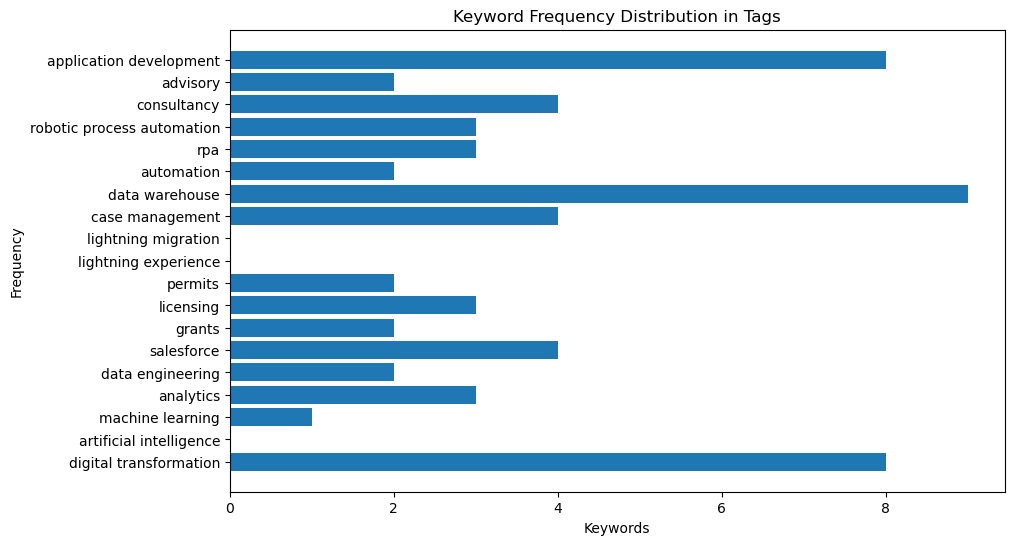

In [74]:
tag_list = [tag for tags in df['Tags'] for tag in tags]
keyword_counts = Counter(tag_list)

# Create a list of counts for each keyword
keyword_frequencies = [keyword_counts[keyword] for keyword in keywords]

# Create a bar plot for the keyword frequencies
plt.figure(figsize=(10, 6))
plt.barh(keywords, keyword_frequencies)
plt.xlabel('Keywords')
plt.ylabel('Frequency')
plt.title('Keyword Frequency Distribution in Tags')
plt.show()

In [75]:
# df['Relevant?'].value_counts()
# df['Predicted Relevance'].value_counts()

In [76]:
# new_df = df[df['Most Relevant Tags'].apply(lambda tags: 'grants' in tags)]
# new_df

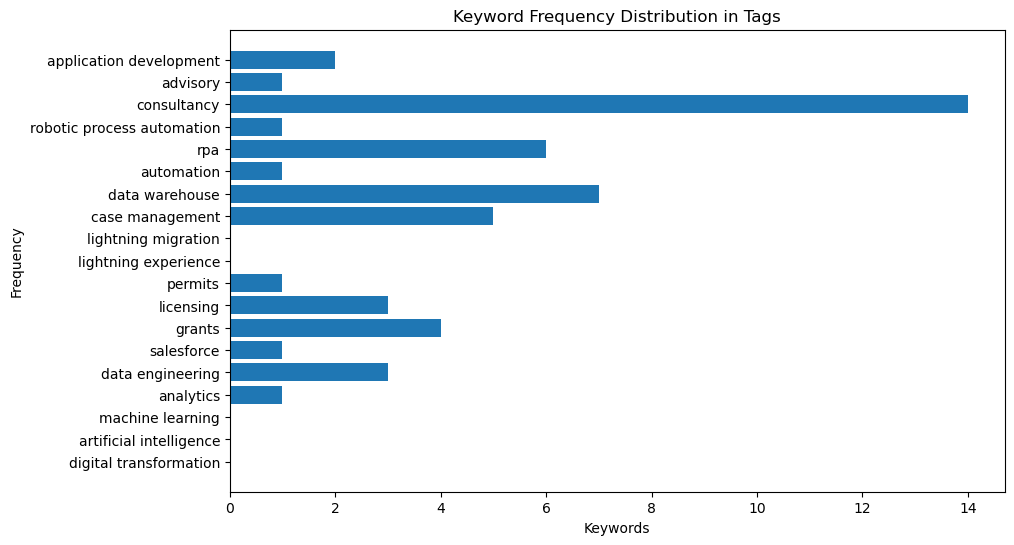

In [77]:
tag_list = [tag for tags in df['Most Relevant Tags'] for tag in tags]
keyword_counts = Counter(tag_list)

# Create a list of counts for each keyword
keyword_frequencies = [keyword_counts[keyword] for keyword in keywords]

# Create a bar plot for the keyword frequencies
plt.figure(figsize=(10, 6))
plt.barh(keywords, keyword_frequencies)
plt.xlabel('Keywords')
plt.ylabel('Frequency')
plt.title('Keyword Frequency Distribution in Tags')
plt.show()

In [78]:
df['Relevant?'] = df['Relevant?'].map({'Yes': True, 'No': False})
df['Predicted Relevance'] = df['Predicted Relevance'].map({'Yes': True, 'No': False})

precision = precision_score(df['Relevant?'], df['Predicted Relevance'])
recall = recall_score(df['Relevant?'], df['Predicted Relevance'])
accuracy = accuracy_score(df['Relevant?'], df['Predicted Relevance'])

print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)

Precision: 0.5588235294117647
Recall: 0.5757575757575758
Accuracy: 0.768


In [79]:
conf_mat = confusion_matrix(df['Relevant?'], df['Predicted Relevance'])
conf_mat

array([[77, 15],
       [14, 19]], dtype=int64)

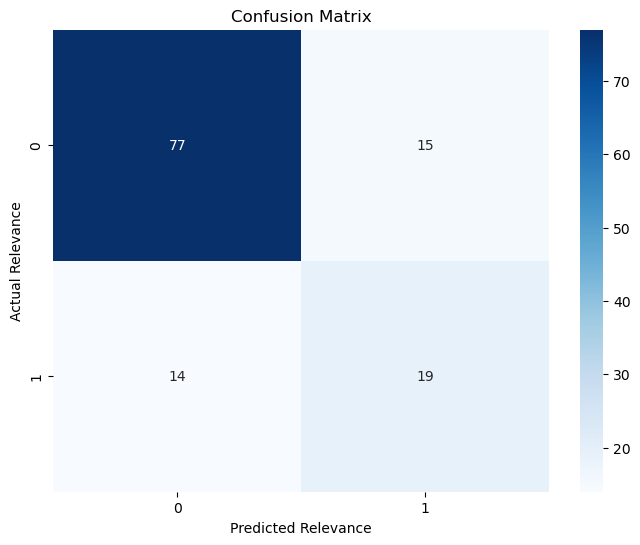

In [80]:
# Plotting Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Relevance')
plt.ylabel('Actual Relevance')
plt.show()

In [81]:
filtered_df = df.loc[(df['Relevant?'] == True) & (df['Predicted Relevance'] == False)]
print(filtered_df['Description'])
print(filtered_df['Tags'])

15                                                 The purpose of the ITN is to seek proposals from one or more qualified vendors to partner with CDLE to build the new Family and Medical Leave Insurance Division (FAMLI) information systems. CDLE is interested in understanding the different capabilities, challenges and technical requirements of developing a Premiums System, Benefits System and Document Management System (DMS). CDLE is hoping for multiple respondents who can provide their expertise and knowledge.\n\nThe new Family and Medical Leave Insurance Division (FAMLI) will provide partial wage-replacement benefits for up to 12 weeks per year to eligible individuals, and employment protections for individuals that take that leave in order to promote the health, safety, and welfare of all Coloradans. The Division of FAMLI will be responsible for ensuring the successful development and implementation of the program in accordance with the law, as enacted through proposition 118. Key t

In [82]:
df.loc[df["Title"] == "DIVISION OF HOUSING LOAN SERVICING SOFTWARE NEEDED"]

,Title,Description,Tags,Relevant?,Most Relevant Tags,Word Count,Predicted Relevance
28,DIVISION OF HOUSING LOAN SERVICING SOFTWARE NEEDED,"Division of Housing Loan Servicing Software Needed\nThe Department of Local Affairs, Division of Housing (DOH) is currently in the process of developing a Grants and Loans on-premises management system utilizing the Salesforce Public Sector Solutions Grants Management platform. Salesforce platforms do not meet the financial components of the business requirements for tracking awarded grant and loan disbursements and servicing and tracking variable and fixed rate loans awarded by DOH’s Office of Housing Finance and Sustainability (OHFS) and Office of Homeless Initiatives (OHI). Therefore DOH is seeking an additional SaaS to meet these requirements. This SaaS must interface with the SFPS system currently in development.\n\nOverview and Goals - Project Purpose\nThe overall grants and loans project must comply with complex statutory and regulatory requirements by employing sophisticated data management, modeling, and analysis layers which will support the use of analysis in business decision making by embedding the results analyzed into business software applications, thereby increasing the efficiency and effectiveness of business users and customers. This will provide data management and analysis staff at DOH with the tools they need to develop and continuously integrate and continuously deploy this functionality in-house so that they can support evolving business needs.\nTo support the overall grants and loans SFPS, DOH is seeking a loan servicing software system that manages the full lifecycle of a loan (not just loan origination), and has, but is not limited to, these key functionalities: initiate payments, track all terms of the loans, determine the loan income for future fiscal year budgets, track and manage all financial payments, interface with state financial system and provide analytical tools for decision-making (see requirements in Section 5).","[grants, salesforce, analysis, machine learning, data engineering]",True,"[grants, case management]",279,True


In [83]:
model.max_seq_length

512